# order_payments_dataset

### Key Columns:
- *payment_installments*
- *payment_value*
- *installment_value*
- *payment_type*

### Foreign Keys:
- *order_id* -> **orders_dataset** NOT UNIQUE VALUES IN THE FOREIGN KEY!!! (**91 602** UNIQUE AFTER PREPROCESSING out of 95 905 -> **group_by** [mean of latitude and longitude] or drop_duplicates)

### Key Findings:
- there are a lot of outliers in *payment_value*
- about $80\%$ of customers pay by card, and $20\%$ pays with boleto
- about $50\%$ of customers pays for the product at once and the other half pays in up to $12$ installments, in general the smaller the number of installments the more frequently it occurs. Over $12$ installments are very rare instances
- the distribution of *payment_value* is left-skewed as there are some outliers with very large price
- the linear correlation between *payment_value* and *payment_installments* is $0.33$, we expected greater coefficient
- after creating new feature *installment_value*, the correlations increased:
    - *installment_value* Vs *payment_value*: $0.53$
    - *installment_value* Vs *payment_installments*: $-0.43$
- apart from that, no strong correlations identified
- after preprocessing *payment_value* and *installment_value* are still skewed but the distribution is a lot better than before

### Preprocessing steps:
- remove outliers from *payment_value*
- change the datatype of *payment_type* to categorical for compression 
- create the new feature *installment_value* as the quotient of *payment_value* and *payment_installments* to indicate the value of a single installment.

### Issues & Clarifications:
- *payment_type* would still need **OneHotEncoding**, it it was to be used
- possibly *installment_value* and *payment_value* could still be adjusted
- foreign key: *order_id* does not have unique values

$7.68\%$ of data has been removed.

## EDA

In [1]:
from utils import (check_functions, 
                       visuals, 
                       cleaning, 
                       preprocessing, 
                       feature_engineering)

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [3]:
order_payments_dataset = pd.read_csv('../data/raw/order_payments_dataset.csv')
order_payments_dataset

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [4]:
order_payments_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [5]:
check_functions.missing_values(order_payments_dataset)

,Column,Missing Values
0,order_id,0
1,payment_sequential,0
2,payment_type,0
3,payment_installments,0
4,payment_value,0


In [6]:
check_functions.nunique_values(order_payments_dataset)

,Column,Nunique,Unique Values
0,order_id,99440,Too Much
1,payment_sequential,29,Too Much
2,payment_type,5,"[credit_card, boleto, voucher, debit_card, not_defined]"
3,payment_installments,24,Too Much
4,payment_value,29077,Too Much


In [7]:
check_functions.duplicates(order_payments_dataset)

There are no duplicates.


In [8]:
numerical_summary, object_summary = check_functions.summarize(order_payments_dataset)

In [9]:
numerical_summary

,count,mean,std,min,25%,50%,75%,max
payment_sequential,103886.0,1.092679,0.706584,1.0,1.00,1.0,1.0000,29.00
payment_installments,103886.0,2.853349,2.687051,0.0,1.00,1.0,4.0000,24.00
payment_value,103886.0,154.100380,217.494064,0.0,56.79,100.0,171.8375,13664.08


In [10]:
object_summary

,count,unique,top,freq
order_id,103886,99440,fa65dad1b0e818e3ccc5cb0e39231352,29
payment_type,103886,5,credit_card,76795


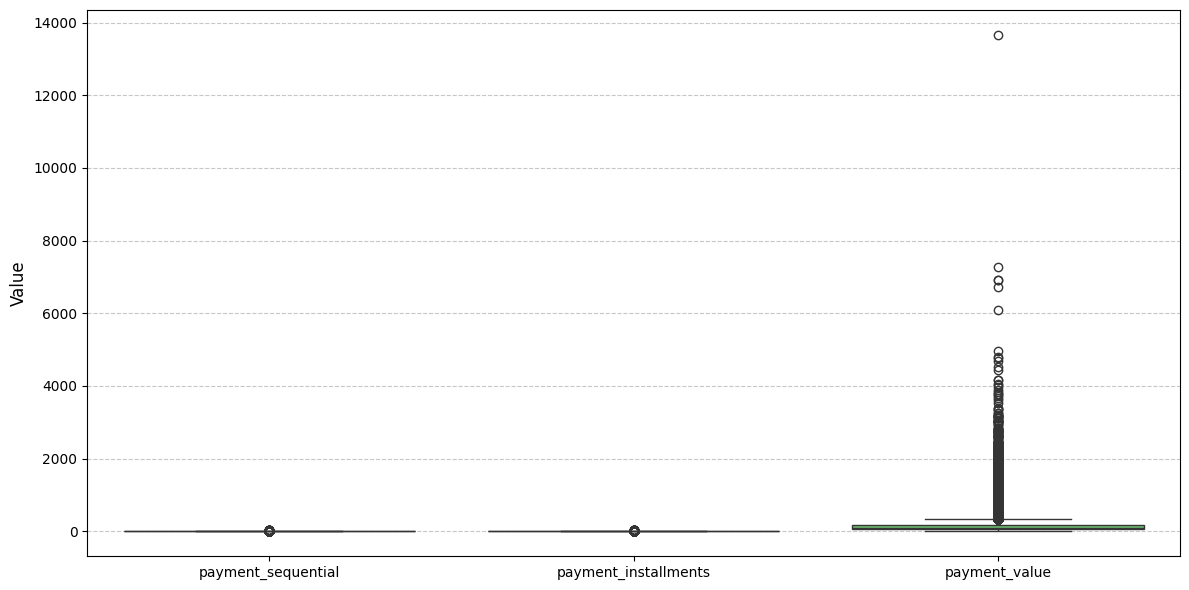

In [11]:
visuals.boxplots(order_payments_dataset, ['payment_sequential', 'payment_installments', 'payment_value'])

In [12]:
check_functions.outliers(order_payments_dataset, ['payment_sequential', 'payment_installments', 'payment_value'])

,Outlier Count,Outlier Percentage (%)
Column,,
payment_value,7981,7.682460
payment_installments,6313,6.076853
payment_sequential,4526,4.356699


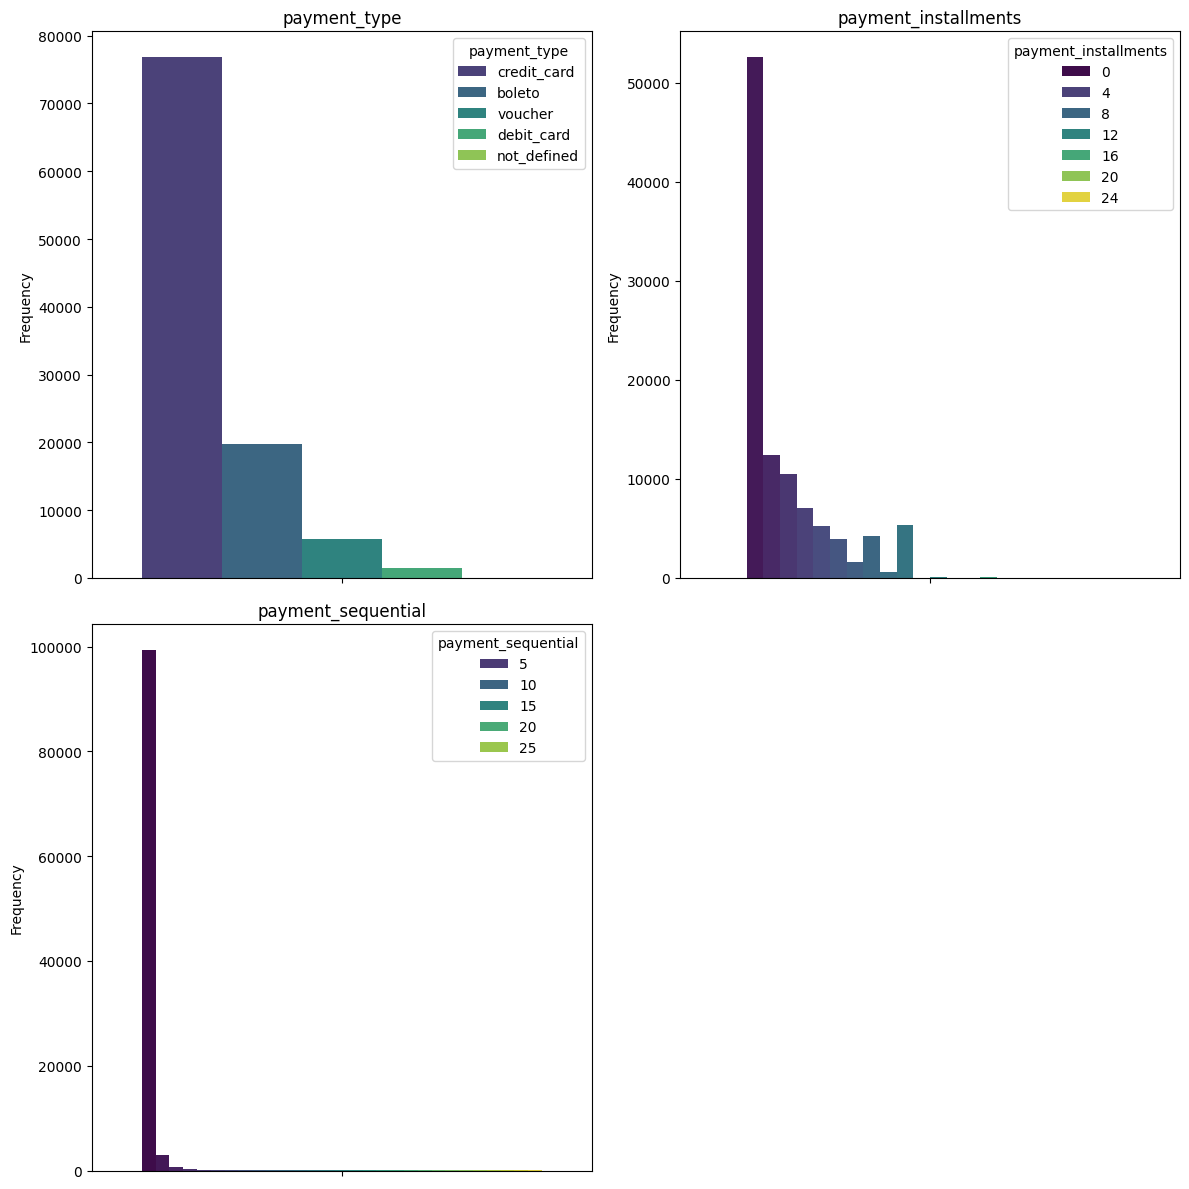

In [13]:
visuals.barplots(order_payments_dataset, ['payment_type', 'payment_installments', 'payment_sequential'])

Most of the payments are done with credit card and the significant majority is paid without installments.

A *boleto* is a payment slip, often used in Brazil, that allows a person to pay for goods or services. It includes a barcode with specific payment details like the amount due, the due date, and the recipient's information. The person can pay the boleto at various authorized locations (such as banks or post offices), or sometimes online.

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\preprocessing\utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


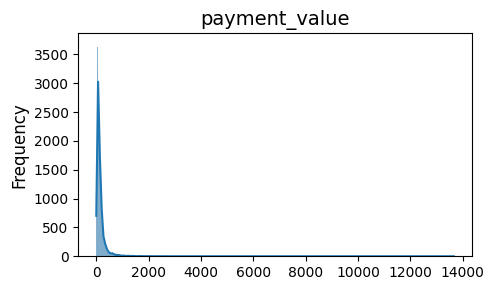

In [14]:
visuals.histograms(order_payments_dataset, ['payment_value'])

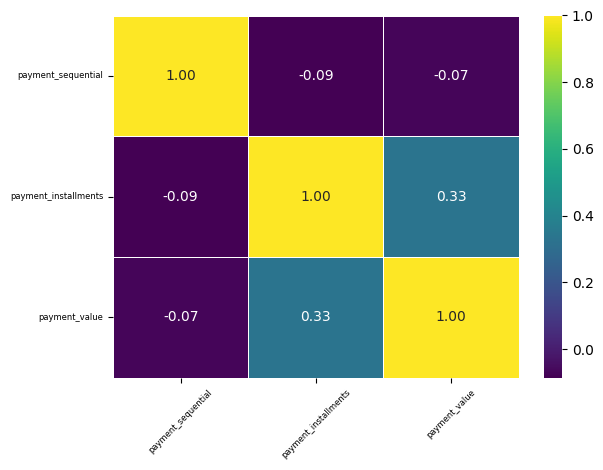

In [15]:
visuals.correlations(order_payments_dataset, ['payment_sequential', 'payment_installments', 'payment_value'])

C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:1615: UserWarning: 

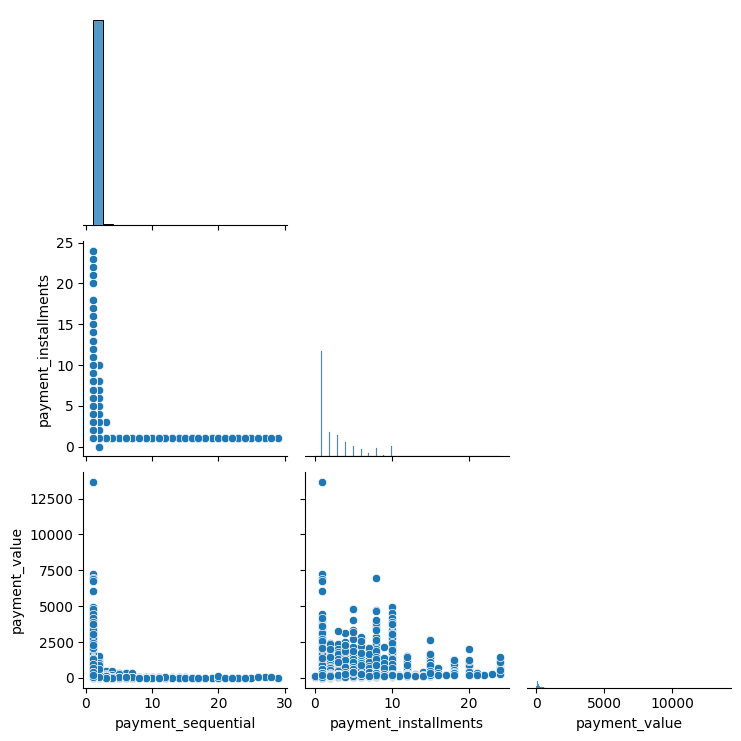

In [16]:
visuals.pairplots(order_payments_dataset, ['payment_sequential', 'payment_installments', 'payment_value'])

There are no correlations.

## Data Cleaning, Preprocessing & Feature Engineering

We delete outliers from the *payment_value* column, change the datatype of *payment_type* to categorical for compression and create the new feature *installment_value* as the quotient of *payment_value* and *payment_installments* to indicate the value of a single installment.

In [17]:
pipeline = make_pipeline(
    cleaning.OutlierRemover_IQR(columns=['payment_value']),
    preprocessing.DataTypeTransformer({'payment_type': 'category'}),
    feature_engineering.FeatureAdder(new_feature_name='installment_value', 
                                     transform_func=lambda X: X['payment_value'] / X['payment_installments']),
)

In [18]:
order_payments_dataset_final = pipeline.fit_transform(order_payments_dataset)
order_payments_dataset_final

,order_id,payment_sequential,payment_type,payment_installments,payment_value,installment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,12.41625
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,24.39000
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,65.71000
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,13.47250
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,64.22500
...,...,...,...,...,...,...
103879,c45067032fd84f4cf408730ff5205568,1,credit_card,2,198.94,99.47000
103880,7159096c5aa9be77f7f0c26c01ee9793,1,credit_card,4,280.65,70.16250
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,48.40000
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,47.77000


In [19]:
order_payments_dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95905 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   order_id              95905 non-null  object  
 1   payment_sequential    95905 non-null  int64   
 2   payment_type          95905 non-null  category
 3   payment_installments  95905 non-null  int64   
 4   payment_value         95905 non-null  float64 
 5   installment_value     95905 non-null  float64 
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 4.5+ MB


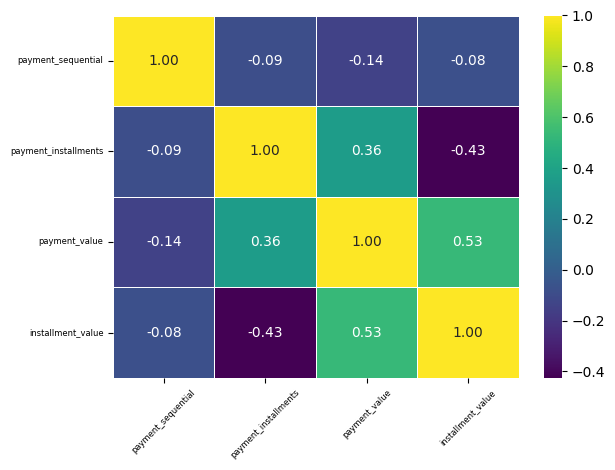

In [20]:
visuals.correlations(order_payments_dataset_final, ['payment_sequential', 'payment_installments', 'payment_value', 'installment_value'])

We were expecting greater values of linear correlation between newly created column and *payment_value* and *payment_installments*. For now it is:
- *installment_value* Vs *payment_value*: $0.53$
- *installment_value* Vs *payment_installments*: $-0.43$

Nevertheless, we should probably not use these columns simultaneously in any model.

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\preprocessing\utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))
c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\preprocessing\utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


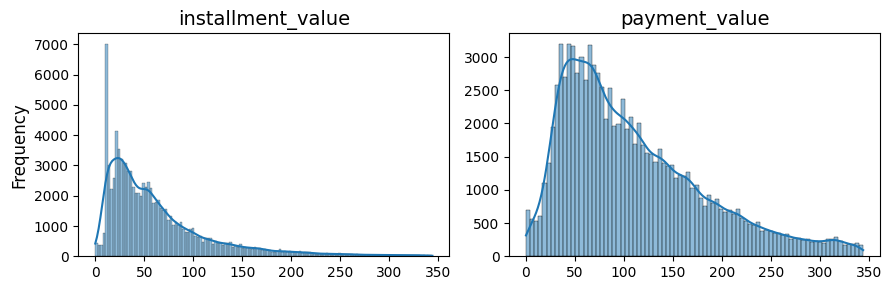

In [21]:
visuals.histograms(order_payments_dataset_final, ['installment_value', 'payment_value'])

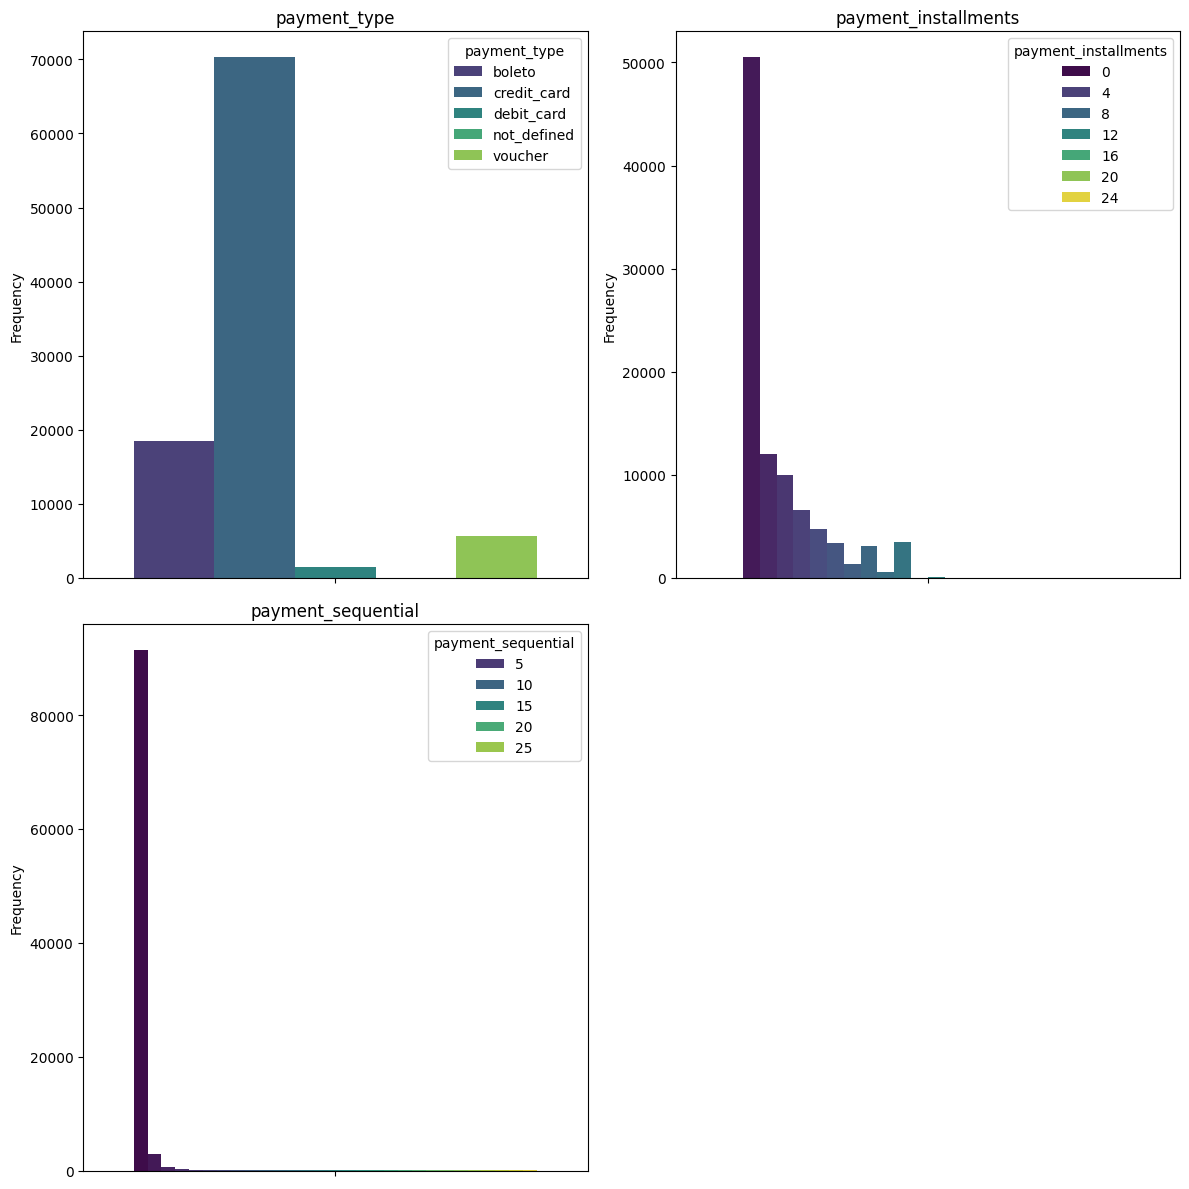

In [22]:
visuals.barplots(order_payments_dataset_final, ['payment_type', 'payment_installments', 'payment_sequential'])

F-1() doprowadzić do rozkładu uniform

In [23]:
# order_payments_dataset_final.to_csv("../data/after/order_payments_dataset_done.csv")